# Features

## 2.1 Exercise - creating input acoustic features
Transform waveform data into fbank feature. And generate metadata for fbank feature files.

In [3]:
import json
import torchaudio
from pathlib import Path
import os
import torch
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
# waveform & fbank transformation function
def generate_fbank(path1, path2, path3):
    # Load the input metadata file
    with open(path1, 'r') as f:
        data = json.load(f)
    
    # Consolidated dictionary for the output JSON
    consolidated_data = {}
    
    # Iterate through each item in the input metadata
    for wav_id, metadata in data.items():
        # Extract the waveform path and metadata
        wav_path = metadata["wav"]
        duration = metadata["duration"]
        spk_id = metadata["spk_id"]
        phn = metadata["phn"]

        # Read the waveform using torchaudio
        waveform, sample_rate = torchaudio.load(wav_path)

        # Generate FBank features
        fbank = torchaudio.compliance.kaldi.fbank(
            waveform,
            sample_frequency = sample_rate,
            use_energy = False,
            num_mel_bins = 23
        )

        # Define the output path for the FBank feature
        speaker_folder = os.path.join(path2, spk_id)
        wav_number = wav_id.split('.')[0]
        Path(speaker_folder).mkdir(parents=True, exist_ok=True)
        fbank_path = os.path.join(speaker_folder, wav_number+'.pt')

        # save the FBank feature
        torch.save(fbank, fbank_path)

        # Populate the consolidated dictionary
        consolidated_data[wav_number] = {
            'fbank': fbank_path,
            'spk_id': spk_id,
            'duration': duration,
            'phn': phn
        }
    
    # save metadata of fbank features
    with open(path3, 'w') as f:
        json.dump(consolidated_data, f, indent=4)
    


path1 = '/home/cz426/rds/hpc-work/MLMI2/exp/json/train.json'
path2 = '/home/cz426/rds/hpc-work/MLMI2/exp/fbank/train'
path3 = '/home/cz426/rds/hpc-work/MLMI2/exp/fbank/train_fbank.json'

# generate train data
generate_fbank(path1, path2, path3)

In [12]:
# generate test data
path1 = '/home/cz426/rds/hpc-work/MLMI2/exp/json/test.json'
path2 = '/home/cz426/rds/hpc-work/MLMI2/exp/fbank/test'
path3 = '/home/cz426/rds/hpc-work/MLMI2/exp/fbank/test_fbank.json'

generate_fbank(path1, path2, path3)

# generate dev data
path1 = '/home/cz426/rds/hpc-work/MLMI2/exp/json/dev.json'
path2 = '/home/cz426/rds/hpc-work/MLMI2/exp/fbank/dev'
path3 = '/home/cz426/rds/hpc-work/MLMI2/exp/fbank/dev_fbank.json'

generate_fbank(path1, path2, path3)

In [ ]:
# check fbank elements
filepath = '/home/cz426/rds/hpc-work/MLMI2/exp/fbank/train/MJRP0/MJRP0_SI585.pt'
data = torch.load(filepath)
print(data.size)

if isinstance(data, torch.Tensor):
    print(f"Tensor shape: {data.shape}")
    print(f"Tensor data (first 5 rows):\n{data[:5]}")
# elif isinstance(data, dict):
#     print(f"Keys in the dictionary: {list(data.keys())}")
#     for key, value in data.items():
#         print(f"{key}: {value}")
# elif isinstance(data, list):
#     print(f"Number of elements in the list: {len(data)}")
    print(f"First element: {data[0]}")
else:
    print(f"Data: {data}")
    

/tmp/ipykernel_4144517/4266509743.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(filepath)


<built-in method size of Tensor object at 0x1487bfd7f930>
Tensor shape: torch.Size([293, 23])
Tensor data (first 5 rows):
tensor([[-15.9424, -15.9424, -15.9424, -15.9424, -15.9424, -13.8551, -11.7190,
         -11.9881, -12.0327, -11.4029, -10.1663, -12.8385, -13.8184, -12.4816,
         -12.2790, -12.2728, -11.9560, -12.6013, -11.6886, -11.7291, -11.1664,
         -10.6782, -10.7492],
        [-15.9424, -15.9424, -15.9424, -15.9424, -15.9424, -14.9231, -12.3207,
         -12.5846, -14.2486, -12.9941, -12.3073, -14.1303, -13.7702, -12.4894,
         -12.3423, -12.4278, -11.9785, -12.1140, -12.0968, -11.1740, -10.8450,
         -10.7170, -10.8127],
        [-15.9424, -15.9424, -15.9424, -15.9424, -15.4558, -15.7608, -15.3994,
         -15.2819, -14.1589, -14.0054, -13.6387, -13.5810, -13.0511, -13.2423,
         -12.2921, -12.1534, -11.9704, -11.6315, -11.4817, -11.5238, -10.9359,
         -10.8459, -10.6870],
        [-15.9424, -15.9424, -15.9424, -15.9424, -15.9424, -15.9424, -15.8156

## Use `dataloader` to get an utterance

# CTC model for ASR

## 2.2 Exercise - Obtain phoneme output units
Phone set and output vocabulary.  
### 2.2.1 Generate vocab_39.txt

In [16]:
# create file vocab_39.txt
with open('/home/cz426/rds/hpc-work/MLMI2/exp/phone_map','r') as f:
    phone_map = f.read()

# create a set of phones from the map
phone_dict = {}
for line in phone_map.strip().split('\n'):
    original_phone, mapped_phone = line.split(': ')
    if mapped_phone:
        phone_dict[original_phone] = mapped_phone

vocab = ['_'] + list(set(phone_dict.values()))

# print(vocab)
# print(len(vocab))

vocab_39_path = '/home/cz426/rds/hpc-work/MLMI2/exp/vocab_39.txt'
with open(vocab_39_path,'w') as f:
    for phone in vocab:
        f.write(f"{phone}\n")


In [4]:
# First find the unique phones in train.json, and then
# create a file named vocab.txt, each line in this 
# file is a unique phone, in total there should be 
# 40 lines

vocab = {}
phonemes = []
with open("vocab_39.txt") as f:
    for id, text in enumerate(f):
        vocab[text.strip()] = id
        phonemes.append(text)
phonemes = phonemes[1:]

In [20]:
vocab

{'_': 0,
 'd': 1,
 'ay': 2,
 'y': 3,
 'iy': 4,
 'uh': 5,
 'th': 6,
 'er': 7,
 'ng': 8,
 'v': 9,
 'b': 10,
 'aa': 11,
 'ch': 12,
 'jh': 13,
 't': 14,
 'dh': 15,
 'k': 16,
 'g': 17,
 'n': 18,
 'l': 19,
 'oy': 20,
 'z': 21,
 's': 22,
 'p': 23,
 'ah': 24,
 'sh': 25,
 'm': 26,
 'sil': 27,
 'dx': 28,
 'eh': 29,
 'ae': 30,
 'ih': 31,
 'aw': 32,
 'r': 33,
 'hh': 34,
 'ow': 35,
 'w': 36,
 'ey': 37,
 'uw': 38,
 'f': 39}

### 2.2.2 Visualise and Comment on training set
Visualise the distribution of phone frequencies in the training set & comment on it.

In [ ]:
# extract the frequencies of each phones
with open('/home/cz426/rds/hpc-work/MLMI2/exp/json/train.json','r') as f:
    train_data = json.load(f)

phoneme_frequencies = Counter()

for key, value in train_data.items():
    phonemes = value.get('phn','').split()
    phoneme_frequencies.update(phonemes)

print(len(phoneme_frequencies))


39


#### Frequency bars visualisation

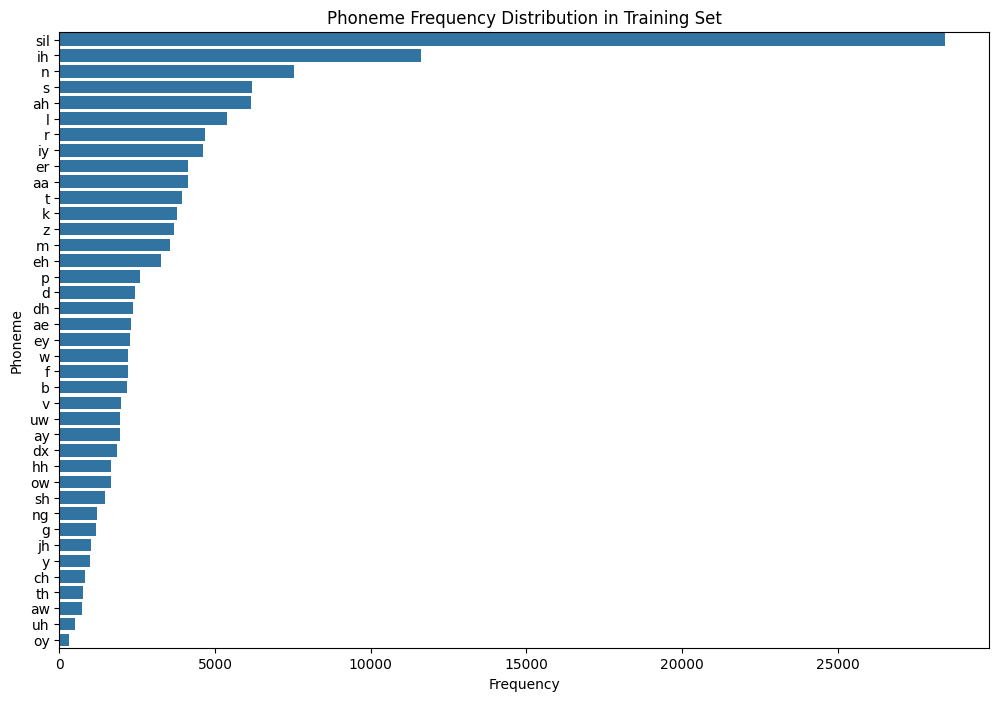

In [27]:
# visualisation
phoneme_list = list(phoneme_frequencies.keys())
frequency_list = list(phoneme_frequencies.values())

# create DataFrame to visualize the distribution
df = pd.DataFrame({
    'phoneme': phoneme_list,
    'frequency': frequency_list
})

df_sorted = df.sort_values(by='frequency',ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='frequency', y='phoneme', data=df_sorted)
plt.title('Phoneme Frequency Distribution in Training Set')
plt.xlabel('Frequency')
plt.ylabel('Phoneme')
plt.show()

#### Word Cloud Visualisation

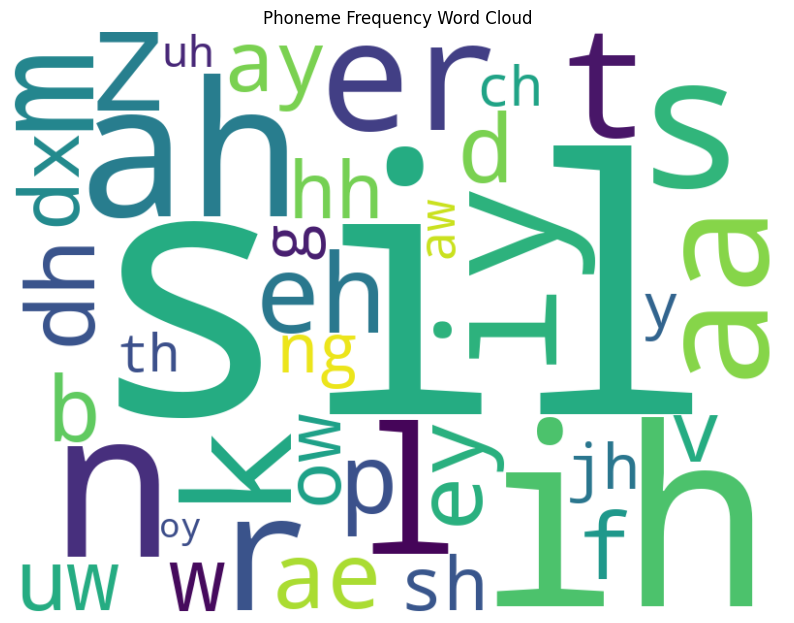

In [31]:
from wordcloud import WordCloud

# Step 4: Create a word cloud based on phoneme frequencies
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(phoneme_frequencies)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Phoneme Frequency Word Cloud')
plt.show()

#### Histogram
Visualize the frequency distribution of phoneme counts (how many phonemes appear with certain frequencies)

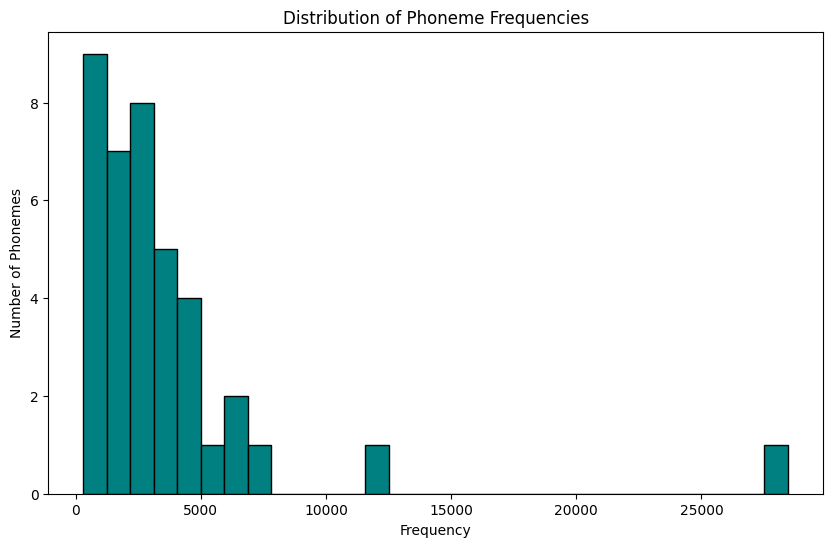

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(frequency_list, bins=30, color='teal', edgecolor='black')
plt.title('Distribution of Phoneme Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Number of Phonemes')
plt.show()

#### Dot Plot

/tmp/ipykernel_4144517/3629896857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='frequency', y='phoneme', data=df_sorted, jitter=True, palette='muted')


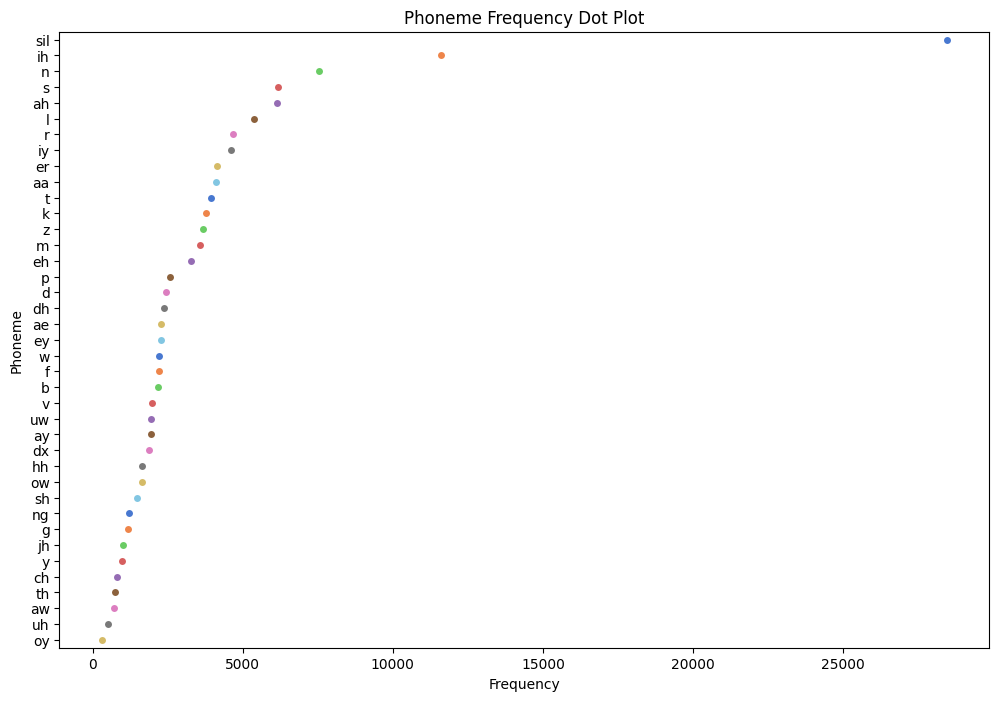

In [33]:
plt.figure(figsize=(12, 8))
sns.stripplot(x='frequency', y='phoneme', data=df_sorted, jitter=True, palette='muted')
plt.title('Phoneme Frequency Dot Plot')
plt.xlabel('Frequency')
plt.ylabel('Phoneme')
plt.show()

## Model & training configurations

In [5]:
# setting argument and model
from collections import namedtuple
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

args = {'seed': 123,
        'train_json': 'train_fbank.json',
        'dev_json': 'dev_fbank.json',
        'test_json': 'test_fbank.json',

        'batch_size': 4,

        'num_layers': 1,
        'fbank_dims': 23,  # number of mel bin, usually 23 or 40
        'model_dims': 128,
        
        'concat': 1,
        'lr': 0.5,
        'vocab': vocab,
        'report_interval': 50,
        'num_epochs': 20,
        'device': device,
       }

args = namedtuple('x', args)(**args)

import models

model = models.BiLSTM(
    args.num_layers, args.fbank_dims * args.concat, args.model_dims, len(args.vocab))
num_params = sum(p.numel() for p in model.parameters())

print('Total number of model parameters is {}'.format(num_params))

Total number of model parameters is 166952


## Training

In [ ]:
from datetime import datetime
from trainer import train

start = datetime.now()
model.to(args.device)
model_path = train(model, args)
end = datetime.now()

duration = (end - start).total_seconds()

print('Training finished in {:.2f} minutes.'.format(duration / 60))
print('Model saved to {}'.format(model_path))

## Decoding

In [3]:
### You can uncomment the following line and change model path to the model you want to decode
# model_path="checkpoints/20221110_120418/model_16"
model_path = '/home/cz426/rds/hpc-work/MLMI2/exp/checkpoints/20241213_165145/model_19'

In [8]:
import torch
print('Loading model from {}'.format(model_path))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Loading model from /home/cz426/rds/hpc-work/MLMI2/exp/checkpoints/20241213_165145/model_19


/tmp/ipykernel_229096/209540675.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


BiLSTM(
  (lstm): LSTM(23, 128, bidirectional=True)
  (proj): Linear(in_features=256, out_features=40, bias=True)
)

In [11]:
from decoder import decode
# results = decode(model, args, args.test_json)
results = decode(model,args,'/home/cz426/rds/hpc-work/MLMI2/exp/fbank/test_fbank.json')
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))

/rds/user/cz426/hpc-work/MLMI2/exp/dataloader.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fbank = torch.load(data_path)


['sil ay sil g r ah dh ah n ah sil b ay dh iy sh uw z ih n sil dh b iy ow v er sil t aa sil d sil t sil']
SUB: 16.88%, DEL: 9.63%, INS: 3.11%, COR: 73.48%, PER: 29.63%


# Attempting

In [1]:
from dataloader import get_dataloader
import torch
from collections import Counter
from datetime import datetime
from trainer import train
import models
from decoder import decode
import numpy as np
import argparse
import random
from collections import namedtuple
import models


if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

# arguments
args = {
    "seed": 123,
    "train_json": "fbank/train_fbank.json",
    "dev_json": "fbank/dev_fbank.json",
    "test_json": "fbank/test_fbank.json",
    "batch_size": 4,
    "num_layers": 2,
    "fbank_dims": 23,
    "model_dims": 128,
    "concat": 1,
    "lr": 0.5,
    "vocab": {
        "_": 0,
        "d": 1,
        "ay": 2,
        "y": 3,
        "iy": 4,
        "uh": 5,
        "th": 6,
        "er": 7,
        "ng": 8,
        "v": 9,
        "b": 10,
        "aa": 11,
        "ch": 12,
        "jh": 13,
        "t": 14,
        "dh": 15,
        "k": 16,
        "g": 17,
        "n": 18,
        "l": 19,
        "oy": 20,
        "z": 21,
        "s": 22,
        "p": 23,
        "ah": 24,
        "sh": 25,
        "m": 26,
        "sil": 27,
        "dx": 28,
        "eh": 29,
        "ae": 30,
        "ih": 31,
        "aw": 32,
        "r": 33,
        "hh": 34,
        "ow": 35,
        "w": 36,
        "ey": 37,
        "uw": 38,
        "f": 39
    },
    "report_interval": 50,
    "num_epochs": 20,
    "max_norm": 1.0,
    # "device": "cuda:0"
    "device":'cpu'
}

args = namedtuple('x', args)(**args)

# define model
model = models.BiLSTM(
    args.num_layers, args.fbank_dims * args.concat, args.model_dims, len(args.vocab),0.5)
num_params = sum(p.numel() for p in model.parameters())

print('Total number of model parameters is {}'.format(num_params))

# load model
model_path = '/home/cz426/rds/hpc-work/MLMI2/exp/checkpoints/20241215_182647/model_20'
print('Loading model from {}'.format(model_path))

# load model to cpu
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.eval()
model.to(device)

# evaluate the model
results = decode(model, args, args.test_json)
print("SUB: {:.2f}%, DEL: {:.2f}%, INS: {:.2f}%, COR: {:.2f}%, PER: {:.2f}%".format(*results))


Total number of model parameters is 562216
Loading model from /home/cz426/rds/hpc-work/MLMI2/exp/checkpoints/20241215_182647/model_20


/tmp/ipykernel_3452242/2176923213.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
/rds/u

SUB: 14.19%, DEL: 7.33%, INS: 1.97%, COR: 78.48%, PER: 23.48%


In [ ]:
# from utils import concat_inputs

# test_loader = get_dataloader(args.test_json, 1, False)

# for data in test_loader:
#     inputs, in_lens, trans, _ = data

#     inputs = inputs.to(args.device)
#     in_lens = in_lens.to(args.device)

#     print('inputs1',inputs)
#     print('lens1',in_lens)

#     inputs, in_lens = concat_inputs(inputs, in_lens, factor=args.concat)

#     print('inputs2:',inputs)
#     print('lens2', in_lens)

In [2]:
from utils import concat_inputs

test_loader = get_dataloader(args.test_json, 1, False)
inputs, in_lens, trans = [], [], []

for data in test_loader:
    inputs.append(data[0])
    in_lens.append(data[1])
    trans.append(data[2])

    # inputs = inputs.to(args.device)
    # in_lens = in_lens.to(args.device)
    # trans = trans.to(args.device)

In [7]:
with torch.no_grad():
    outputs = torch.nn.functional.softmax(model(inputs[2]), dim=-1)  # probabilities
    print(outputs)
    print(outputs.shape)

    # outputs = torch.argmax(outputs, dim=-1).transpose(0, 1)  # the largest probabilities
    # print(outputs)
    # print(outputs.shape)

tensor([[[2.9789e-03, 3.3024e-06, 3.5123e-08,  ..., 1.4193e-08,
          5.6814e-08, 1.7545e-06]],

        [[4.8632e-03, 7.4461e-07, 2.7086e-09,  ..., 1.1735e-09,
          9.7997e-09, 6.7020e-08]],

        [[9.9865e-01, 2.7364e-06, 1.3755e-08,  ..., 2.5017e-09,
          7.3965e-09, 4.0403e-08]],

        ...,

        [[1.0000e+00, 1.1051e-08, 9.7372e-10,  ..., 4.4421e-11,
          2.3505e-10, 2.5854e-10]],

        [[1.0000e+00, 1.1605e-08, 2.4656e-09,  ..., 1.0083e-10,
          5.3312e-10, 3.7861e-10]],

        [[9.9999e-01, 4.1611e-08, 1.8176e-08,  ..., 8.7962e-10,
          5.4496e-09, 1.3904e-09]]])
torch.Size([204, 1, 40])


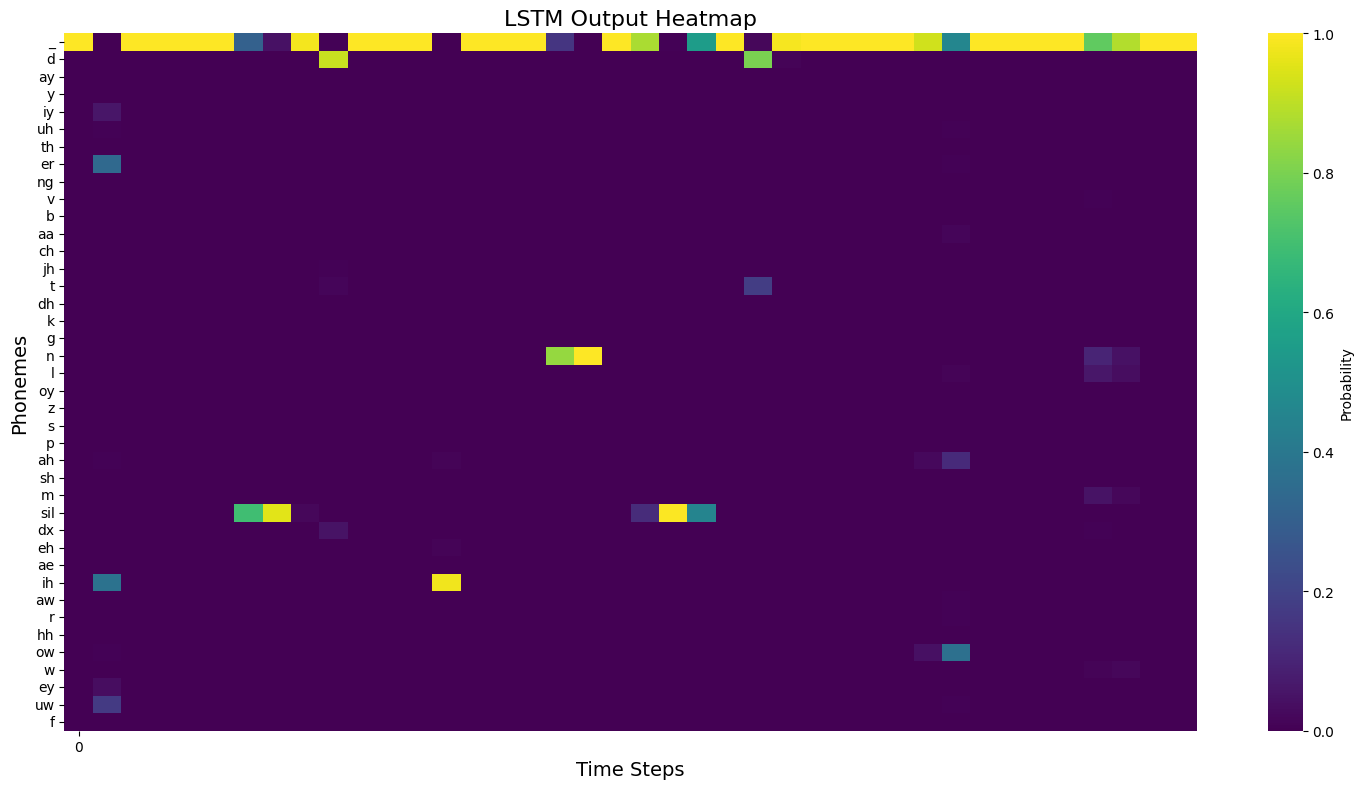

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

output = outputs.squeeze(1) 

# read phones
with open("/home/cz426/rds/hpc-work/MLMI2/exp/vocab_39.txt", "r") as f:
    phonemes = [line.strip() for line in f]

# transform output into list
output_np = output.detach().numpy()

output_np = output_np[60:100, :]  # 取前 50 个时间步

plt.figure(figsize=(15, 8))
# 绘制热力图
sns.heatmap(
    output_np.T,  # 转置以将音素作为 y 轴，时间步作为 x 轴
    cmap="viridis",  # 颜色映射（可以尝试其他，如 "magma", "coolwarm"）
    xticklabels=50,  # 每隔 50 个时间步显示一次标签
    yticklabels=phonemes,  # 音素名称作为 y 轴标签
    cbar_kws={"label": "Probability"},  # 颜色条的标签
    vmin=0, vmax=1  # 概率范围固定在 [0, 1]
)

# 添加标题和轴标签
plt.title("LSTM Output Heatmap", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Phonemes", fontsize=14)

# 显示图形
plt.tight_layout()
plt.show()

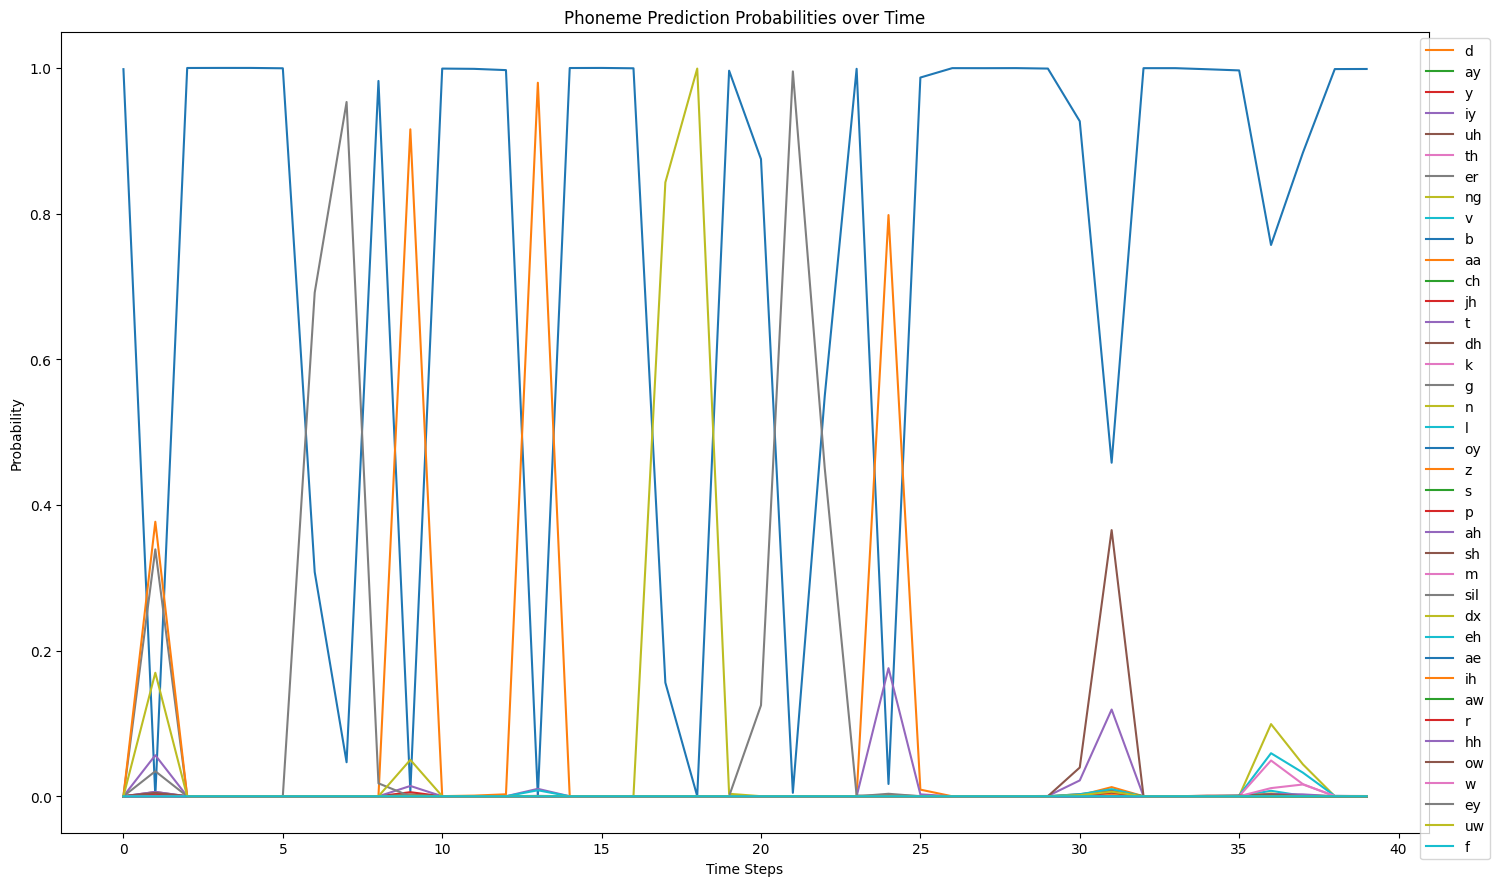

In [18]:
plt.figure(figsize=(15, 9.5))
for i in range(len(phonemes)):
    plt.plot(output_np[:, i], label=phonemes[i])
plt.xlabel("Time Steps")
plt.ylabel("Probability")
plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
plt.title("Phoneme Prediction Probabilities over Time")
plt.tight_layout()
plt.show()
